<a href="https://colab.research.google.com/github/Glamonica123/Projects/blob/master/90dayCryptoLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import requests
import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

In [ ]:

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Bidirectional, Dropout, Dense, GRU, Conv1D, MaxPooling1D, Flatten, Input, Attention, Add
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
)

In [ ]:
# 1) Download daily historical data (no multi-level columns)
coin="ETH"
df = yf.download(
    tickers=f"{coin}-USD",
    start="2017-01-01",
    end="2024-12-31",
    interval="1d",
    group_by="column"   # <--- prevents multi-level columns
)

# 2) Convert the DatetimeIndex into a normal "Date" column
df.reset_index(inplace=True)

# 3) Show the first rows
print("Sample of downloaded data:")
print(df.head())

# 4) Save to CSV WITHOUT the index
csv_filename = f"{coin.lower}_yahoo_history.csv"
df.to_csv(csv_filename, index=False)
print(f"\nSaved historical data to {csv_filename}.")

# 5) Reload the CSV, parsing the "Date" column
df_reloaded = pd.read_csv(csv_filename, parse_dates=["Date"])
df_reloaded.set_index("Date", inplace=True)
print("\nSample of reloaded data from CSV:")
print(df_reloaded.head())

[*********************100%***********************]  1 of 1 completed

Sample of downloaded data:
Price        Date   Adj Close       Close        High         Low        Open  \
Ticker                ETH-USD     ETH-USD     ETH-USD     ETH-USD     ETH-USD   
0      2017-11-09  320.884003  320.884003  329.451996  307.056000  308.644989   
1      2017-11-10  299.252991  299.252991  324.717987  294.541992  320.670990   
2      2017-11-11  314.681000  314.681000  319.453003  298.191986  298.585999   
3      2017-11-12  307.907990  307.907990  319.153015  298.513000  314.690002   
4      2017-11-13  316.716003  316.716003  328.415009  307.024994  307.024994   

Price       Volume  
Ticker     ETH-USD  
0        893249984  
1        885985984  
2        842300992  
3       1613479936  
4       1041889984  

Saved historical data to <built-in method lower of str object at 0x7daf6da3a870>_yahoo_history.csv.

Sample of reloaded data from CSV:
                     Adj Close               Close                High  \
Date                                            

In [ ]:
df_reloaded.head()

,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
NaT,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
2017-11-09,320.8840026855469,320.8840026855469,329.4519958496094,307.0559997558594,308.6449890136719,893249984
2017-11-10,299.25299072265625,299.25299072265625,324.7179870605469,294.5419921875,320.6709899902344,885985984
2017-11-11,314.6809997558594,314.6809997558594,319.4530029296875,298.1919860839844,298.58599853515625,842300992
2017-11-12,307.9079895019531,307.9079895019531,319.15301513671875,298.51300048828125,314.69000244140625,1613479936


In [ ]:
csv_filename = f"{coin.lower}_yahoo_history.csv"
df.to_csv(csv_filename, index=False)
print(f"\nSaved historical data to {csv_filename}.")

# 5) Reload the CSV, parsing the "Date" column
df_reloaded = pd.read_csv(csv_filename, parse_dates=["Date"])
df_reloaded.set_index("Date", inplace=True)
print("\nSample of reloaded data from CSV:")
print(df_reloaded.head())

df.drop(columns=["Volume"], inplace=True)

# 2) Round price columns to one decimal place
price_cols = ["Open", "High", "Low", "Close", "Adj Close"]
df[price_cols] = df[price_cols].round(1)

# (Optional) Ensure 'Date' is the DataFrame index
# If not, run:
# df.set_index("Date", inplace=True)
#
# NOTE: If you used df.reset_index() earlier, that's fine as long as
# 'Close' and other columns are still accessible.

print("Data after dropping Volume and rounding price columns:")
df.head()
features = df[["Open", "High", "Low", "Close"]].values

windows = []
targets = []
sequence_length = 90  # 90-day lookback

# 2) Build sequences (X) and labels (y)
for i in range(len(features) - sequence_length):
    # X_window will have shape (90, 4)
    X_window = features[i : i + sequence_length, :]

    # Let's predict next day's 'Close'
    # Day (i + sequence_length) is the day after the 90-day window
    y_label = features[i + sequence_length, 3]  # index 3 is 'Close'

    windows.append(X_window)
    targets.append(y_label)

# 3) Convert to NumPy arrays
windows = np.array(windows)
# shape = (num_samples, 90, 4)

targets = np.array(targets).reshape(-1, 1)
# shape = (num_samples, 1)

print("Shape of windows:", windows.shape)
print("Shape of targets:", targets.shape)

num_samples = windows.shape[0]
sequence_length = windows.shape[1]
num_features = windows.shape[2]

# 1) Flatten the time & feature dimensions -> 2D for scaling
windows_2d = windows.reshape((num_samples, sequence_length * num_features))
# shape => (num_samples, 90*4)

# 2) Scale the windows
scaler_X = MinMaxScaler(feature_range=(0,1))
windows_sc_2d = scaler_X.fit_transform(windows_2d)

# 3) Reshape back to (samples, timesteps=90, features=4)
windows_sc = windows_sc_2d.reshape((num_samples, sequence_length, num_features))

print("Scaled windows shape:", windows_sc.shape)

# 4) Scale the targets
scaler_y = MinMaxScaler(feature_range=(0,1))
targets_sc = scaler_y.fit_transform(targets)  # shape => (num_samples, 1)

print("Scaled targets shape:", targets_sc.shape)
split_index = int(0.8 * num_samples)

X_train = windows_sc[:split_index]
X_test  = windows_sc[split_index:]
y_train = targets_sc[:split_index]
y_test  = targets_sc[split_index:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
model = Sequential()
model.add(LSTM(
    units=200,
    input_shape=(X_train.shape[1], X_train.shape[2])  # (timesteps=90, features=4)
))
model.add(Dropout(0.2))
model.add(Dense(sequence_length))  # Predict 90 days of prices (instead of 1 price)

model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
model.summary()
model_checkpoint = ModelCheckpoint(
    'best_model.weights.h5',  # Must end with .weights.h5 when save_weights_only=True
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,    # Save only the weights
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)
# Train
history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=64,
    validation_data=(X_test, y_test),
    verbose=1,               # Set to 1 for progress bar; set to 0 to suppress
    callbacks=[early_stopping, model_checkpoint]
)

Data after dropping Volume and rounding price columns:


<ipython-input-5-ca2a707c353a>:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(columns=["Volume"], inplace=True)


Price,Date,Adj Close,Close,High,Low,Open
Ticker,,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
0,2017-11-09,320.9,320.9,329.5,307.1,308.6
1,2017-11-10,299.3,299.3,324.7,294.5,320.7
2,2017-11-11,314.7,314.7,319.5,298.2,298.6
3,2017-11-12,307.9,307.9,319.2,298.5,314.7
4,2017-11-13,316.7,316.7,328.4,307.0,307.0


Shape of windows: (2516, 90, 4)
Shape of targets: (2516, 1)


Scaled windows shape: (2516, 90, 4)
Scaled targets shape: (2516, 1)


X_train shape: (2012, 90, 4)
y_train shape: (2012, 1)
X_test shape: (504, 90, 4)
y_test shape: (504, 1)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 200)                 │         164,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 90)                  │          18,090 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,090 (711.29 KB)

 Trainable params: 182,090 (711.29 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - loss: 0.0581
Epoch 1: val_loss improved from inf to 0.00431, saving model to best_model.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - loss: 0.0571 - val_loss: 0.0043
Epoch 2/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0042
Epoch 2: val_loss improved from 0.00431 to 0.00158, saving model to best_model.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 259ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 3/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - loss: 0.0031
Epoch 3: val_loss improved from 0.00158 to 0.00153, saving model to best_model.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 278ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 4/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - loss: 0.0026
Epoch 4: val_loss improved from 0.00153 to 0.00126, saving model to best_model.weights.h5
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 226ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 5/25
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - loss: 0.0023
Epoch 5

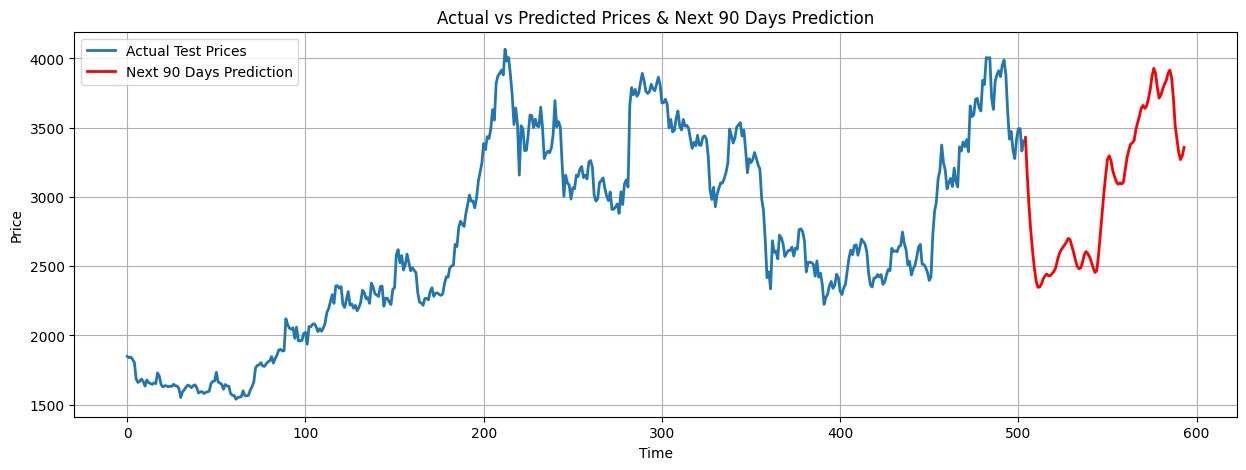

Predicted prices for the next 90 days: [3428.7803, 3158.0615, 2930.5437, 2753.6624, 2609.9329, 2485.6694, 2390.8547, 2347.8035, 2349.4624, 2372.524, 2408.3604, 2431.6965, 2442.5996, 2430.9534, 2432.2737, 2447.432, 2462.9646, 2490.3035, 2545.744, 2589.1206, 2616.5583, 2636.4363, 2654.4094, 2674.3218, 2700.5776, 2691.6838, 2646.7886, 2600.1506, 2546.4636, 2499.9897, 2482.3977, 2487.0684, 2527.467, 2581.941, 2605.7024, 2590.5728, 2566.6997, 2530.246, 2488.7104, 2454.7332, 2467.6282, 2578.5312, 2726.9922, 2876.2153, 3027.2642, 3153.038, 3269.9624, 3296.721, 3262.14, 3189.3242, 3147.036, 3110.6125, 3091.491, 3101.342, 3093.028, 3109.0078, 3197.3132, 3281.2124, 3338.344, 3380.6519, 3390.3728, 3408.797, 3488.6128, 3537.7612, 3584.6567, 3641.1506, 3660.4436, 3639.8984, 3656.2473, 3708.7085, 3774.1167, 3870.1997, 3928.3906, 3890.391, 3791.087, 3713.8823, 3735.9675, 3778.2576, 3813.5938, 3840.5688, 3890.3328, 3915.7986, 3862.8594, 3716.375, 3517.0815, 3417.8657, 3321.6462, 3269.4263, 3295.915, 3

In [ ]:
# Step 1: Make predictions on the test set
y_pred_scaled = model.predict(X_test,verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Inverse scale to get actual prices
y_actual = scaler_y.inverse_transform(y_test)  # Actual values from test set

# Step 2: Predict the next 90 days (one single prediction)
# Use the last available sequence from the test set
last_sequence = X_test[-1]  # Last sequence from the test set
predicted_90_days = []  # To store the next 90 days predictions

# Predict next 90 days one by one
for _ in range(sequence_length):
    next_scaled = model.predict(last_sequence[np.newaxis, :, :],verbose=0)  # Predict next step
    next_price = scaler_y.inverse_transform(next_scaled)[0, 0]  # Inverse scale the predicted price

    predicted_90_days.append(next_price)  # Store prediction

    # Update the sequence for the next prediction
    last_sequence = np.roll(last_sequence, -1, axis=0)
    last_sequence[-1, -1] = next_scaled[0, 0]  # Update with predicted scaled Close price

# Step 3: Plot results: Actual vs Predicted Prices and Next 90 Days Prediction
plt.figure(figsize=(15, 5))

# Plot actual test prices
plt.plot(y_actual, label="Actual Test Prices", linewidth=2)


# Plot next 90 days predictions
plt.plot(range(len(y_actual), len(y_actual) + 90), predicted_90_days, label="Next 90 Days Prediction", color='red', linewidth=2)

# Set plot title and labels
plt.title("Actual vs Predicted Prices & Next 90 Days Prediction")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Output the predicted next 90 days
print("Predicted prices for the next 90 days:", predicted_90_days)


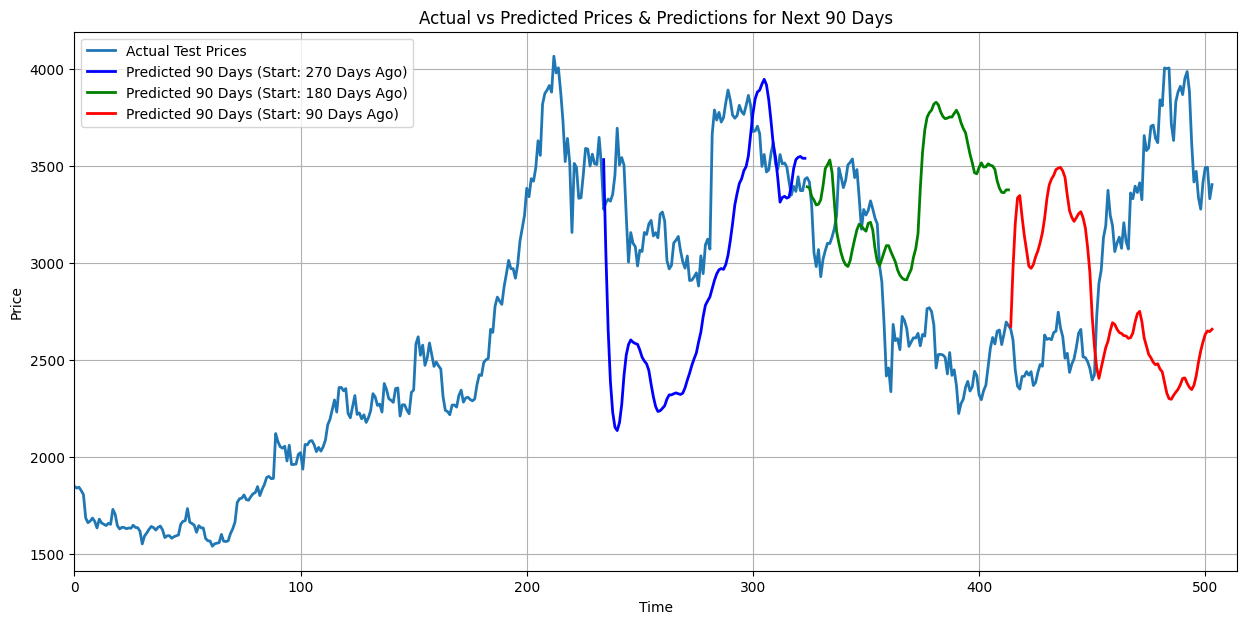

In [ ]:
# Step 1: Make predictions on the test set
y_pred_scaled = model.predict(X_test, verbose=0)
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Inverse scale to get actual prices
y_actual = scaler_y.inverse_transform(y_test)  # Actual values from test set

# Step 2: Predict the next 90 days from different starting points
# Function to predict 90 days starting from a given sequence
def predict_next_90_days(start_sequence):
    predictions = []
    sequence = start_sequence.copy()
    for _ in range(90):  # Predict 90 days
        next_scaled = model.predict(sequence[np.newaxis, :, :], verbose=0)  # Predict next step
        next_price = scaler_y.inverse_transform(next_scaled)[0, 0]  # Inverse scale the predicted price
        predictions.append(next_price)  # Store prediction
        sequence = np.roll(sequence, -1, axis=0)  # Shift sequence left
        sequence[-1, -1] = next_scaled[0, 0]  # Update with predicted scaled Close price
    return predictions

# Predict for last 90, 180, and 270 days
predicted_90_days_from_270 = predict_next_90_days(X_test[-270])  # Starting from 270 days ago
predicted_90_days_from_180 = predict_next_90_days(X_test[-180])  # Starting from 180 days ago
predicted_90_days_from_90 = predict_next_90_days(X_test[-90])    # Starting from 90 days ago

# Step 3: Plot results: Actual vs Predicted Prices and Next 90 Days Predictions
plt.figure(figsize=(15, 7))

# Plot actual test prices
plt.plot(y_actual, label="Actual Test Prices", linewidth=2)



# Define the lengths for reference
test_length = len(y_actual)

# Plot next 90 days predictions from different starting points
# Align predictions based on their starting points in the test set

# Prediction starting from 270 days ago
start_270 = test_length - 270
end_270 = start_270 + 90
plt.plot(
    range(start_270, end_270),
    predicted_90_days_from_270,
    label="Predicted 90 Days (Start: 270 Days Ago)",
    color="blue",
    linewidth=2,
)

# Prediction starting from 180 days ago
start_180 = test_length - 180
end_180 = start_180 + 90
plt.plot(
    range(start_180, end_180),
    predicted_90_days_from_180,
    label="Predicted 90 Days (Start: 180 Days Ago)",
    color="green",
    linewidth=2,
)

# Prediction starting from 90 days ago
start_90 = test_length - 90
end_90 = start_90 + 90
plt.plot(
    range(start_90, end_90),
    predicted_90_days_from_90,
    label="Predicted 90 Days (Start: 90 Days Ago)",
    color="red",
    linewidth=2,
)

# Optionally, extend the x-axis if any predictions go beyond the test set
max_end = max(end_270, end_180, end_90)
plt.xlim(0, max_end + 10)  # Add some padding for clarity

# Set plot title and labels
plt.title("Actual vs Predicted Prices & Predictions for Next 90 Days")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
y_pred.shape

(504, 90)

In [ ]:
y_test.shape

(504, 1)

In [ ]:
result=model.predict(X_test[1:])

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step


In [ ]:
result[:,0].shape

(503,)

In [ ]:
X_test[1:2].shape

(1, 90, 4)

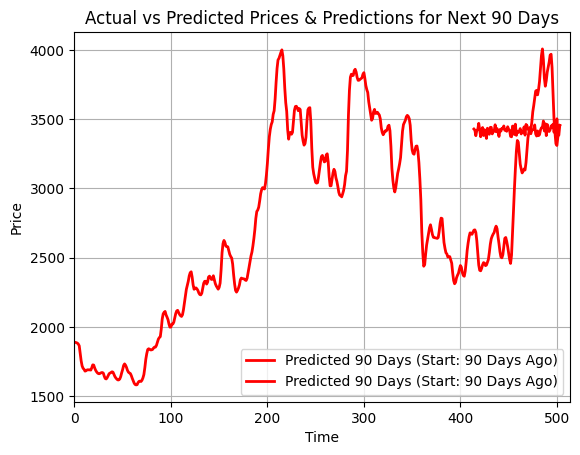

In [ ]:
plt.plot(
    range(y_pred.shape[0]),
    y_pred[:,-1],
    label="Predicted 90 Days (Start: 90 Days Ago)",
    color="red",
    linewidth=2,
)
plt.plot(
    range(start_90, end_90),
    y_pred[-1,:],
    label="Predicted 90 Days (Start: 90 Days Ago)",
    color="red",
    linewidth=2,
)

# Optionally, extend the x-axis if any predictions go beyond the test set
max_end = max(end_270, end_180, end_90)
plt.xlim(0, max_end + 10)  # Add some padding for clarity

# Set plot title and labels
plt.title("Actual vs Predicted Prices & Predictions for Next 90 Days")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
y_pred.shape[0]

504